In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8a550363-269a-a361-b7d8-5935bda8d958)


In [2]:
# Import series of helper functions for our project
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [3]:
#unzip the dataset stored in google drive
!unzip "/content/drive/MyDrive/Raw_dataset/10_food_classes_all_data.zip" -d "/content/drive/MyDrive/Data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Data/10_food_classes_all_data/train/hamburger/2119225.jpg  
  inflating: /content/drive/MyDrive/Data/__MACOSX/10_food_classes_all_data/train/hamburger/._2119225.jpg  
  inflating: /content/drive/MyDrive/Data/10_food_classes_all_data/train/hamburger/22923.jpg  
  inflating: /content/drive/MyDrive/Data/__MACOSX/10_food_classes_all_data/train/hamburger/._22923.jpg  
  inflating: /content/drive/MyDrive/Data/10_food_classes_all_data/train/hamburger/3894442.jpg  
  inflating: /content/drive/MyDrive/Data/__MACOSX/10_food_classes_all_data/train/hamburger/._3894442.jpg  
  inflating: /content/drive/MyDrive/Data/10_food_classes_all_data/train/hamburger/1101890.jpg  
  inflating: /content/drive/MyDrive/Data/__MACOSX/10_food_classes_all_data/train/hamburger/._1101890.jpg  
  inflating: /content/drive/MyDrive/Data/10_food_classes_all_data/train/hamburger/2715888.jpg  
  inflating: /content/drive/MyDrive/Data/__MA

In [4]:
# Import Relevant libraries
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, GlobalAvgPool2D, Input
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import callbacks, optimizers
import numpy as np

In [64]:
# get the data dir
train_dir = "/content/drive/MyDrive/Data/10_food_classes_all_data/train/"
test_dir = "/content/drive/MyDrive/Data/10_food_classes_all_data/test/"

In [23]:
# How many images/classes are there?
walk_through_dir("/content/drive/MyDrive/Data/10_food_classes_all_data")

There are 2 directories and 0 images in '/content/drive/MyDrive/Data/10_food_classes_all_data'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Data/10_food_classes_all_data/test/hamburger'.
There 

## Setup data inputs

In [31]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Create checkpoint callback

In [51]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## Create data augmentation layer to incorporate it right to the model

In [42]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

##Setup base model and freeze its layers


In [48]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in inference mode so weights which needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

258088960/258076736 [==============================] - 2s 0us/step


## Get a summary of the model created

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_avg_pool_layer (Glob  (None, 2560)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                25610     
                                                                 
Total params: 64,123,297
Trainable params: 25,610
Non-trainab

## Compile the model

In [50]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## Fit the Model

In [52]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/10
235/235 [==============================] - 224s 872ms/step - loss: 0.9910 - accuracy: 0.6980 - val_loss: 0.7182 - val_accuracy: 0.7443
Epoch 2/10
235/235 [==============================] - 167s 709ms/step - loss: 0.6960 - accuracy: 0.7783 - val_loss: 0.6439 - val_accuracy: 0.7756
Epoch 3/10
235/235 [==============================] - 146s 621ms/step - loss: 0.6317 - accuracy: 0.7991 - val_loss: 0.6138 - val_accuracy: 0.7812
Epoch 4/10
235/235 [==============================] - 139s 590ms/step - loss: 0.5918 - accuracy: 0.8123 - val_loss: 0.5567 - val_accuracy: 0.8153
Epoch 5/10
235/235 [==============================] - 133s 565ms/step - loss: 0.5693 - accuracy: 0.8187 - val_loss: 0.5740 - val_accuracy: 0.7983
Epoch 6/10
235/235 [==============================] - 127s 538ms/step - loss: 0.5451 - accuracy: 0.8179 - val_loss: 0.6016 - val_accuracy: 0.7926
Epoch 7/10
235/235 [==============================] - 128s 542ms/step - loss: 0.5386 - accuracy: 0.8279 - val_loss: 0.5324 -

### Evaluate on the whole test data

In [53]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

79/79 [==============================] - 29s 360ms/step - loss: 0.3606 - accuracy: 0.8836


[0.3606061041355133, 0.8835999965667725]

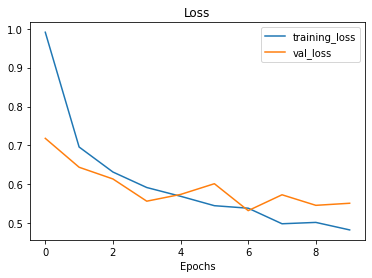

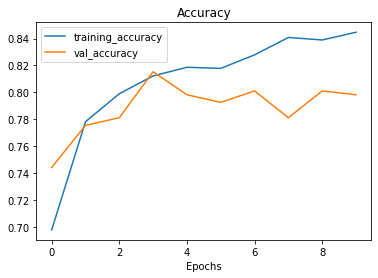

In [55]:
#plot loss curves
plot_loss_curves(history)

### Making predictions with our trained model

In [56]:
# Make predictions on the model
preds_prob = model.predict(test_data, verbose=1)

79/79 [==============================] - 31s 337ms/step


In [57]:
# Get the pred classes of each label
pred_classes = preds_prob.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 7, 0, 0, 0, 0, 0, 0, 0, 0])

In [58]:
# To get our test labels we need to unravel our test_data Batchdataset
y_labels = []

for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Let's get visual: making a confusion matrix

In [59]:
from helper_functions import make_confusion_matrix

In [60]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Visualizing predictions on test_data

In [61]:
# Create a function to load and pepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into 
  specified shape (224, 224, 3)

  Args:
  filename (str): path to target image
  image_shape (int): height/weight dimension of target image size
  scale (bool): scale pixel value from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (224, 224, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 & 1)
    return img/255.
  else:
    return img
    

In [62]:
import matplotlib.pyplot as plt

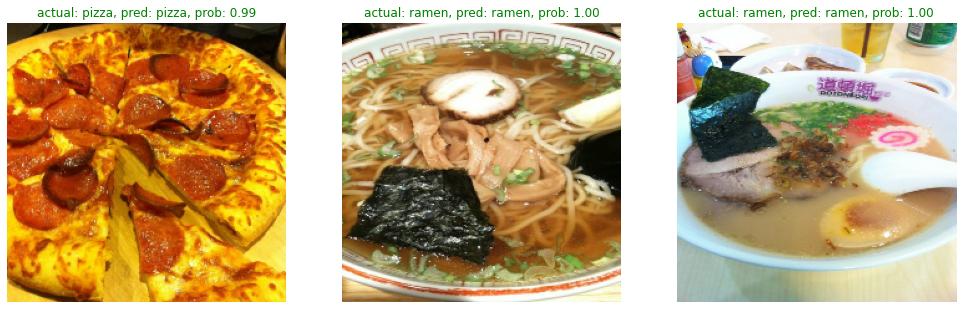

In [65]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

In [67]:
# Get all of the image file paths in the test data
filepaths = []
for filepath in test_data.list_files("/content/drive/MyDrive/Data/10_food_classes_all_data/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/101833.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/10340.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1035626.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1048226.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1075859.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1076489.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/108559.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1095245.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1125163.jpg',
 b'/content/drive/MyDrive/Data/10_food_classes_all_data/test/chicken_curry/1134602.jpg']

In [68]:
# Create a Dataframe of different parameters for each of our test images
import pandas as pd

pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_prob.max(axis=1), # Get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.918481,chicken_curry,chicken_curry
1,b'/content/drive/MyDrive/Data/10_food_classes_...,0,7,0.707029,chicken_curry,ramen
2,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.995914,chicken_curry,chicken_curry
3,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.547959,chicken_curry,chicken_curry
4,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.919299,chicken_curry,chicken_curry


In [69]:
# Find out in our dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.918481,chicken_curry,chicken_curry,True
1,b'/content/drive/MyDrive/Data/10_food_classes_...,0,7,0.707029,chicken_curry,ramen,False
2,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.995914,chicken_curry,chicken_curry,True
3,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.547959,chicken_curry,chicken_curry,True
4,b'/content/drive/MyDrive/Data/10_food_classes_...,0,0,0.919299,chicken_curry,chicken_curry,True


In [70]:
# Sort our dataframe to have most wrong predictions
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
1039,b'/content/drive/MyDrive/Data/10_food_classes_...,4,8,0.993257,hamburger,steak,False
1602,b'/content/drive/MyDrive/Data/10_food_classes_...,6,4,0.992418,pizza,hamburger,False
44,b'/content/drive/MyDrive/Data/10_food_classes_...,0,2,0.980422,chicken_curry,fried_rice,False
2333,b'/content/drive/MyDrive/Data/10_food_classes_...,9,4,0.961755,sushi,hamburger,False
246,b'/content/drive/MyDrive/Data/10_food_classes_...,0,2,0.957627,chicken_curry,fried_rice,False
737,b'/content/drive/MyDrive/Data/10_food_classes_...,2,8,0.955763,fried_rice,steak,False
2467,b'/content/drive/MyDrive/Data/10_food_classes_...,9,8,0.944001,sushi,steak,False
2263,b'/content/drive/MyDrive/Data/10_food_classes_...,9,3,0.935056,sushi,grilled_salmon,False
650,b'/content/drive/MyDrive/Data/10_food_classes_...,2,7,0.924677,fried_rice,ramen,False
2437,b'/content/drive/MyDrive/Data/10_food_classes_...,9,3,0.917541,sushi,grilled_salmon,False


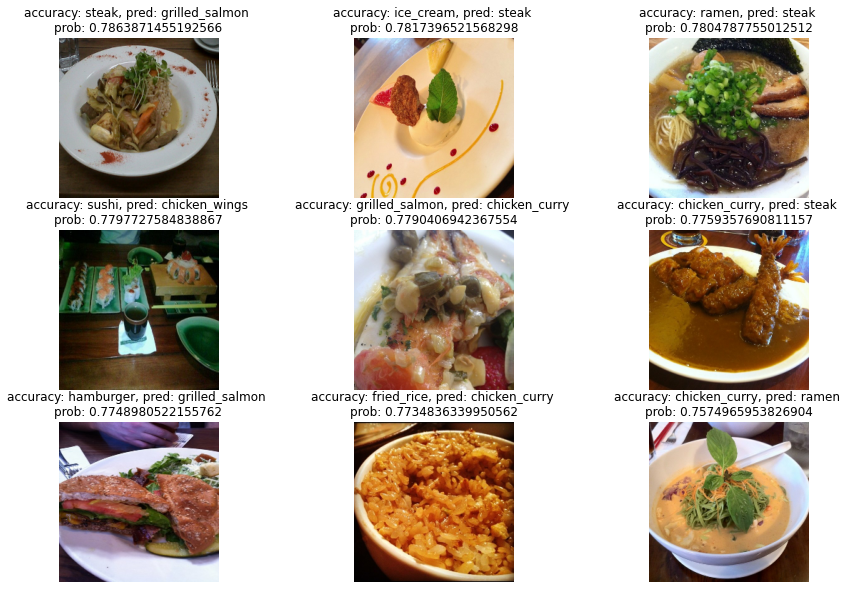

In [71]:
# Visualize the test data samples which have the wrong predictions but high pred
images_to_view = 9
start_index = 40
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"accuracy: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
    plt.axis(False)

### Test out our model on custom images

In [72]:
!unzip "/content/drive/MyDrive/Raw_dataset/custom_image_to_predict.zip" -d "/content/drive/MyDrive/Data"

Archive:  /content/drive/MyDrive/Raw_dataset/custom_image_to_predict.zip
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/chicken curry.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/chicken curry-2.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/fried rice.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/grilled salmon.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/hamburger.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/ice cream.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/pizza.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/ramen.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/rice_fried.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/steak.jpg  
  inflating: /content/drive/MyDrive/Data/custom_image_to_predict/sushi.jpg  


In [75]:
# Get the custom food image filepahs
custom_food_images = ["/content/drive/MyDrive/Data/custom_food_images/"+ img_path for img_path in os.listdir("/content/drive/MyDrive/Data/custom_food_images")]
custom_food_images

['/content/drive/MyDrive/Data/custom_food_images/chicken curry.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/chicken curry-2.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/fried rice.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/grilled salmon.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/hamburger.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/ice cream.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/pizza.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/ramen.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/rice_fried.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/steak.jpg',
 '/content/drive/MyDrive/Data/custom_food_images/sushi.jpg']

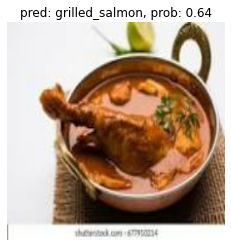

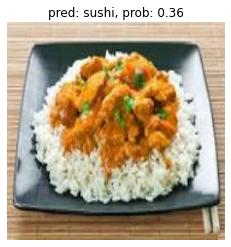

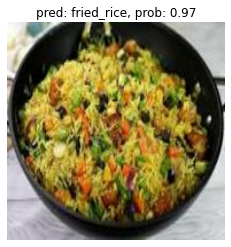

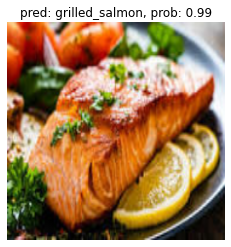

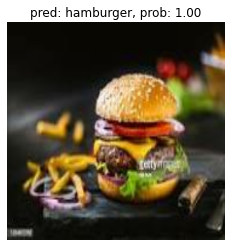

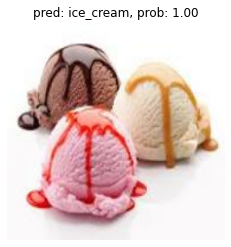

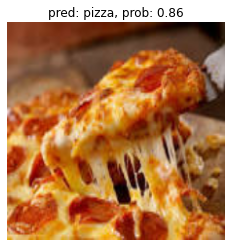

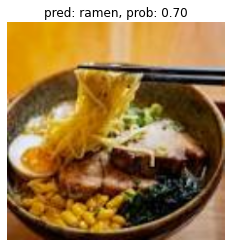

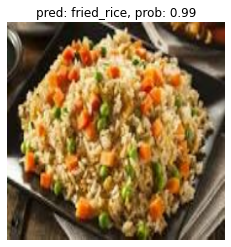

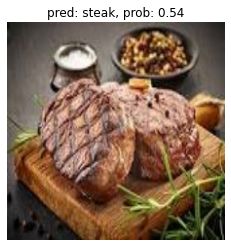

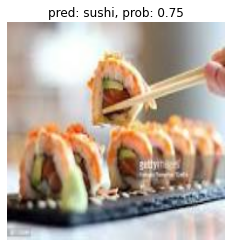

In [76]:
# Make predictions on custom food images and plot them
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

### Saving the model

In [77]:
model.save("/content/drive/MyDrive/Saved Models/10-Food-Class-Vision.h5")